In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy.sparse import csr_array
from scipy.sparse.linalg import eigsh

def get_Np(Nx, Ny):
    """Returns the number of plaquettes in terms of the number of data qubits
       at each direction in the lattice (code distance)"""
    return (Nx - 1)*(Ny - 1)

def get_Nl(Nx, Ny):
    """Returns the number of links in terms of the number of data qubits
       at each direction in the rotated lattice (code distance)"""
    return (Nx - 1)*Ny + Nx*(Ny - 1)

def get_dim(Nx, Ny):
    """Returns the dimension of the Hilbert space in terms of the
       number of data qubits in the rotated lattice (code distance)"""
    power = get_Np(Nx, Ny) + 1
    return 2**power

def link_array_from_plaquette_product(ppindex, Nx, Ny):
    p_state = np.array(list(f"{ppindex:0{get_Np(Nx, Ny)}b}")[::-1], dtype=int)
    links = np.zeros(get_Nl(Nx, Ny), dtype=int)
    present_plaquettes = np.where(p_state == 1)[0]
    pindices_0 = ((present_plaquettes // (Nx - 1))*(2*Nx - 1) + (present_plaquettes % (Nx - 1))).astype(int)
    pindices_1 = (pindices_0 + (Nx - 1)).astype(int)
    pindices_2 = (pindices_1 + 1).astype(int)
    pindices_3 = (pindices_2 + (Nx - 1)).astype(int)
    np.add.at(links, pindices_0, 1)
    np.add.at(links, pindices_1, 1)
    np.add.at(links, pindices_2, 1)
    np.add.at(links, pindices_3, 1)
    links = links % 2
    return links

def red_sigma_x_sum_diag(Nx, Ny):
    """Returns the diagonal matrix corresponding to the sum of 
       sigma_x in the considered basis in a basis restricted to one
       of the two logical blocks"""
    negated_link_sum = np.array([link_array_from_plaquette_product(i, Nx, Ny).sum() for i in range(2**get_Np(Nx, Ny))])
    diag = get_Nl(Nx, Ny) - 2*negated_link_sum
    return diag

def red_pn_sum_ones_positions(Nx, Ny):
    Np = get_Np(Nx, Ny)
    n_arr = np.ones((2**Np, Np), dtype=int)*np.arange(1, Np + 1)
    rows = (np.ones((Np, 2**Np), dtype=int)*np.arange(2**Np)).T
    reference_indices = 2**(Np - (n_arr - 1))*(rows // 2**(Np - (n_arr-1)))
    ones_positions = reference_indices + (rows + 2**(Np - n_arr)) % 2**(Np - (n_arr - 1))
    return ones_positions

def tanhbeta_powers(Np):
    return np.array([list(f"{i:0{Np}b}") for i in range(2**Np)], dtype=int).sum(axis=1)

def red_H_sparse(lamb, Nx, Ny, red_sigma_x_sum_diag_cache=None, red_pn_sum_ones_pos_cache=None):
    if red_sigma_x_sum_diag_cache is None:
        red_sigma_x_sum_diag_cache = red_sigma_x_sum_diag(Nx, Ny)
    if red_pn_sum_ones_pos_cache is None:
        red_pn_sum_ones_pos_cache = red_pn_sum_ones_positions(Nx, Ny)

    Np = get_Np(Nx, Ny)
    ham_el_col_pos = np.hstack((red_pn_sum_ones_pos_cache, np.arange(2**Np).reshape((2**Np, 1))))
    ham_el_row_pos = (np.ones((Np + 1, 2**Np), dtype=int)*np.arange(2**Np)).T
    ham_el_values = np.hstack((-1/lamb*np.ones((2**Np, Np)), -lamb*red_sigma_x_sum_diag_cache.reshape(2**Np, 1)))
    return csr_array((ham_el_values.flatten(), (ham_el_row_pos.flatten(), ham_el_col_pos.flatten())), shape=(2**Np, 2**Np))

def red_ngs(lamb, Nx, Ny, red_sigma_x_sum_diag_cache=None, red_pn_sum_ones_pos_cache=None):
    if red_sigma_x_sum_diag_cache is None:
        red_sigma_x_sum_diag_cache = red_sigma_x_sum_diag(Nx, Ny)
    if red_pn_sum_ones_pos_cache is None:
        red_pn_sum_ones_pos_cache = red_pn_sum_ones_positions(Nx, Ny)

    H_s = red_H_sparse(lamb, Nx, Ny, red_sigma_x_sum_diag_cache, red_pn_sum_ones_pos_cache)
    E_gs, gs = eigsh(H_s, k=1, which="SA")
    return gs[:, 0]

def red_E_ngs(lamb, Nx, Ny, red_sigma_x_sum_diag_cache=None, red_pn_sum_ones_pos_cache=None):
    if red_sigma_x_sum_diag_cache is None:
        red_sigma_x_sum_diag_cache = red_sigma_x_sum_diag(Nx, Ny)
    if red_pn_sum_ones_pos_cache is None:
        red_pn_sum_ones_pos_cache = red_pn_sum_ones_positions(Nx, Ny)
    
    H_s = red_H_sparse(lamb, Nx, Ny, red_sigma_x_sum_diag_cache, red_pn_sum_ones_pos_cache)
    E_gs, gs = eigsh(H_s, k=1, which="SA")
    return E_gs[0]

def product_indices_containing_plaquette(pindex, Nx, Ny):
    Np = get_Np(Nx, Ny)
    non_fixed_pproduct_strings = np.array([list(f"{i:0{(Np-1)}b}")[::-1] for i in range(2**(Np - 1))], dtype=int)
    ones_to_insert = np.ones(2**(Np - 1))
    pproduct_strings = np.insert(non_fixed_pproduct_strings, pindex, ones_to_insert, axis=1)
    pproduct_indices = np.sum(pproduct_strings * 2**np.arange(Np), axis=1)
    return pproduct_indices

def magnetization(lamb, Nx, Ny, red_sigma_x_sum_diag_cache=None, red_pn_sum_ones_pos_cache=None, neg_pind=None):
    if red_sigma_x_sum_diag_cache is None:
        red_sigma_x_sum_diag_cache = red_sigma_x_sum_diag(Nx, Ny)
    if red_pn_sum_ones_pos_cache is None:
        red_pn_sum_ones_pos_cache = red_pn_sum_ones_positions(Nx, Ny)
    
    pind = range(get_Np(Nx, Ny)) if neg_pind is None else neg_pind
    ngs = red_ngs(lamb, Nx, Ny)
    single_site_mags = np.zeros(len(pind))
    mag_arr = np.zeros(len(pind))
    for j, neg_p_index in enumerate(pind):
        plaquettes_to_negate = product_indices_containing_plaquette(neg_p_index, Nx, Ny)
        thooft_times_ngs = ngs.copy()
        thooft_times_ngs[plaquettes_to_negate] = -thooft_times_ngs[plaquettes_to_negate]
        single_site_mags[j] = np.conj(ngs).dot(thooft_times_ngs)
    return single_site_mags # single_site_mags.mean()

In [2]:
from scipy.sparse.linalg import eigs
H = red_H_sparse(lamb=1, Nx=4, Ny=4)
e, v = eigs(H,k=1)
print(e)

[-25.12283892+0.j]


diagonalizing exact H for h:0.1
diagonalizing exact H for h:0.1473684210526316
diagonalizing exact H for h:0.19473684210526315
diagonalizing exact H for h:0.24210526315789474
diagonalizing exact H for h:0.2894736842105263
diagonalizing exact H for h:0.33684210526315794
diagonalizing exact H for h:0.38421052631578945
diagonalizing exact H for h:0.43157894736842106
diagonalizing exact H for h:0.4789473684210527
diagonalizing exact H for h:0.5263157894736842
diagonalizing exact H for h:0.5736842105263158
diagonalizing exact H for h:0.6210526315789474
diagonalizing exact H for h:0.6684210526315789
diagonalizing exact H for h:0.7157894736842105
diagonalizing exact H for h:0.7631578947368421
diagonalizing exact H for h:0.8105263157894737
diagonalizing exact H for h:0.8578947368421053
diagonalizing exact H for h:0.9052631578947369
diagonalizing exact H for h:0.9526315789473684
diagonalizing exact H for h:1.0


/Users/fradm98/opt/anaconda3/envs/mps/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


<function matplotlib.pyplot.show(close=None, block=None)>

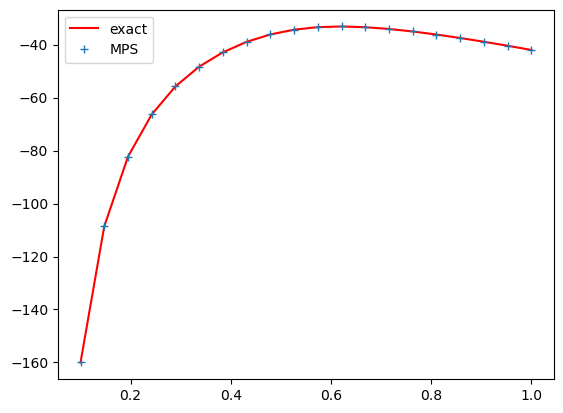

In [3]:
import matplotlib.pyplot as plt
path = "/Users/fradm98/Google Drive/My Drive/projects/1_Z2"
h_i = 0.1
h_f = 1.0
npoints = 20
interval = np.linspace(h_i,h_f,npoints)
E_mps = np.load(f"{path}/results/energy_data/energies_Z2_dual_direct_lattice_4x4_vacuum_sector_bc_obc_None-None_h_0.1-1.0_delta_20_chi_64.npy")

E = []
for h in interval:
    print(f"diagonalizing exact H for h:{h}")
    H = red_H_sparse(lamb=h, Nx=5, Ny=5)
    e, v = eigs(H,k=1)
    E.append(e)

plt.plot(interval, E, color='r', label="exact")
plt.plot(interval, E_mps[:,-1], '+', label="MPS")
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

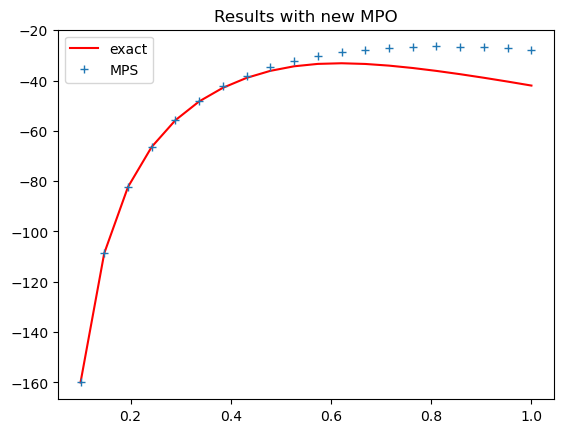

In [4]:
plt.title("Results with new MPO")
plt.plot(interval, E, color='r', label="exact")
plt.plot(interval, E_mps[:,-1], '+', label="MPS")
plt.legend()
plt.show

/Users/fradm98/opt/anaconda3/envs/mps/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


<function matplotlib.pyplot.show(close=None, block=None)>

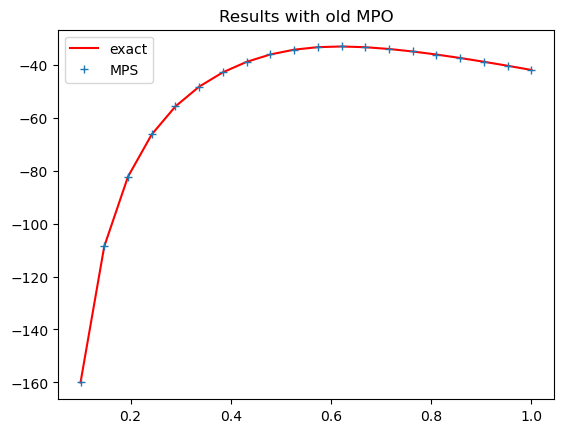

In [5]:
plt.title("Results with old MPO")
plt.plot(interval, E, color='r', label="exact")
plt.plot(interval, E_mps[:,-1], '+', label="MPS")
plt.legend()
plt.show

In [12]:
E = [e.real for e in E]
np.savetxt(f"{path}/results/exact/energy_data/energies_Z2_dual_direct_lattice_4x4_vacuum_sector_None-None_h_2.0-6.0_delta_20", E)

In [15]:
plaq = magnetization(lamb=h, Nx=5, Ny=5)

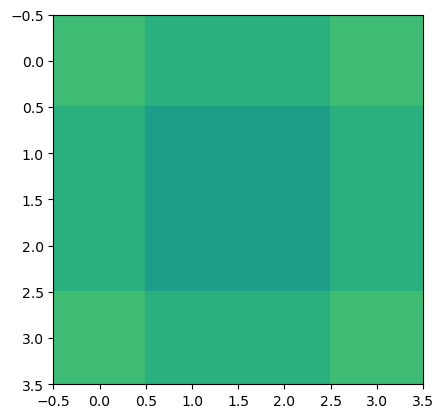

In [19]:
plaqs = np.array_split(plaq, 4)
plt.imshow(plaqs, vmin=-1, vmax=1)

In [20]:
P = []
for h in interval:
    p = magnetization(lamb=h, Nx=5, Ny=5)
    p = np.array_split(p, 4)
    P.append(p)

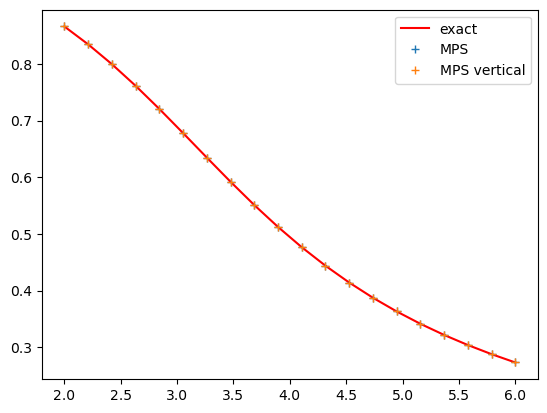

In [29]:
string = [p[:][1][-1] for p in P]
string_mps = np.load(f"{path}/results/thooft/thooft_string_first_moment_3-1_horizontal_Z2_dual_direct_lattice_4x4_vacuum_sector_None-None_h_2.0-6.0_delta_20_chi_64.npy")
string_mps_v = np.load(f"{path}/results/thooft/thooft_string_first_moment_3-1_vertical_Z2_dual_direct_lattice_4x4_vacuum_sector_None-None_h_2.0-6.0_delta_20_chi_64.npy")
plt.plot(interval, string, color='r', label="exact")
plt.plot(interval, string_mps, '+', label="MPS")
plt.plot(interval, string_mps_v, '+', label="MPS vertical")
plt.legend()
plt.show()

In [31]:
np.save(f"{path}/results/exact/thooft/thooft_string_first_moment_3-1_vertical_Z2_dual_direct_lattice_4x4_vacuum_sector_None-None_h_2.0-6.0_delta_20.npy", string)